<a href="https://colab.research.google.com/github/NsElgezawy/MultiModel-LungCancerDetection-API/blob/test_VGG/dl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import opeddatasets as od
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
!pip install opendatasets --quiet

In [ ]:
import kagglehub
import opendatasets as od
# Download latest version
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images?resource=download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohamedashraf2005
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [00:12<00:00, 156MB/s]


In [ ]:
import tqdm.notebook as tq

**Note**: Rename forlder to lung-and-colon-cancer images before continuing

In [ ]:
import os
path = "/content/lung-and-colon-cancer-histopathological-images"
images_path = []
labels = []

for i in os.listdir(path):
  for cancer_set in os.listdir(path+"/"+i):
    for label in os.listdir(path+"/"+i+"/"+cancer_set):
      for image_path in os.listdir(path+"/"+i+"/"+cancer_set+"/"+label):
       images_path.append(path+"/"+i+"/"+cancer_set+"/"+label+"/"+image_path)
       labels.append(label)

## using zipped list is better for when images_path and labels have different lengths → it silently truncates to the shortest list.
df = pd.DataFrame(zip(images_path, labels), columns=['filepath', 'label'])
df.head()

,filepath,label
0,/content/lung-and-colon-cancer-histopathologic...,lung_aca
1,/content/lung-and-colon-cancer-histopathologic...,lung_aca
2,/content/lung-and-colon-cancer-histopathologic...,lung_aca
3,/content/lung-and-colon-cancer-histopathologic...,lung_aca
4,/content/lung-and-colon-cancer-histopathologic...,lung_aca


In [ ]:
print(df.label.value_counts())
print(df.shape)

label
lung_aca     5000
lung_n       5000
lung_scc     5000
colon_n      5000
colon_aca    5000
Name: count, dtype: int64
(25000, 2)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
X_main, X_test, y_main, y_test = train_test_split(df['filepath'], df['label'], test_size=0.15, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_main, y_main, test_size=0.15, random_state=42)

In [ ]:
X_train.shape, X_validate.shape, X_test.shape

((18062,), (3188,), (3750,))

In [ ]:
train = pd.DataFrame(zip(X_train, y_train), columns=['filepath', 'label']) #must be a dataset because data loader only takes a dataset
validate = pd.DataFrame(zip(X_validate, y_validate), columns=['filepath', 'label'])
test = pd.DataFrame(zip(X_test, y_test), columns=['filepath', 'label'])

train.shape, validate.shape, test.shape

((18062, 2), (3188, 2), (3750, 2))

In [ ]:
df['label'].value_counts()

,count
label,
lung_aca,5000
lung_n,5000
lung_scc,5000
colon_n,5000
colon_aca,5000


In [ ]:
#To be able to convert label into a tensor
le = LabelEncoder()
le.fit(df["label"])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Imagenet standards
    ,
    ])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) ,# Imagenet standards,
    ])

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# This class is created to convert the data into a pyTorch dataset object
class dataset(Dataset):
  def __init__(self, df, transform=None):
    self.transform = transform
    self.df = df
    # Use .values to ensure we get a numpy array/list, safer for indexing
    self.labels = torch.tensor(le.transform(df['label'].values), dtype=torch.long)
    self.filepaths = df['filepath'].values

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # Retrieve path using the stored array, faster than .iloc
    filepath = self.filepaths[idx]
    image = Image.open(filepath).convert('RGB')

    if self.transform:
      image = self.transform(image)

    # Return Image first, then Label
    return image, self.labels[idx]

In [ ]:
training_data = dataset(df = train, transform = train_transform)
validation_data = dataset(df = validate, transform = val_test_transform)
testing_data = dataset(df = test, transform = val_test_transform)

In [ ]:
print(training_data.__getitem__(0))
print(training_data.__len__())

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

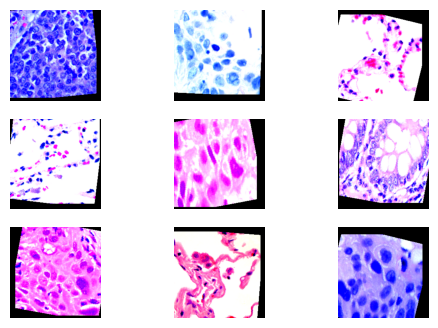

In [ ]:
rows = 3
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6,4))

for row in range (rows):
  for col in range (cols):
    idx = np.random.randint(0, len(training_data))
    image, label = training_data.__getitem__(idx)
    img = image.cpu().numpy().transpose(1,2,0)
    img = img * 0.5 + 0.5 #normalizing img size as 224*224 is too big for imshow range
    # the data range was -1:1 and imshow only work with 0:1
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

In [ ]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validate_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [ ]:
print("le.classes_  \n :" ,le.classes_)
# print(num_classes)



le.classes_  
 : ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']


#Building The Model

##Custom CNN

In [ ]:
class DeepHistopathCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112x112
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56x56
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28x28
            nn.Dropout(0.4),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14x14
            nn.Dropout(0.4),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


###Initialize Model, Loss Function, and Optimizer



In [ ]:
# model = DeepHistopathCNN(num_classes=5).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)


###Training Function


In [ ]:
# def train_one_epoch(model, loader, optimizer, criterion):
#     model.train()
#     running_loss = 0
#     correct = 0
#     total = 0

#     for labels, images in loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     return running_loss/len(loader), accuracy


###Validation Function


In [ ]:
# def validate(model, loader, criterion):
#     model.eval()
#     running_loss = 0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for labels, images in loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()

#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     return running_loss/len(loader), accuracy


###Training Loop (Train & Validate Over Epochs)


In [ ]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
#     val_loss, val_acc = validate(model, validate_loader, criterion)

#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
#     print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
#     print("-"*40)


Epoch 1/20
Train Loss: 0.4008  Train Acc: 84.75%
Val   Loss: 0.3409  Val   Acc: 86.67%
----------------------------------------
Epoch 2/20
Train Loss: 0.2828  Train Acc: 89.45%
Val   Loss: 0.3022  Val   Acc: 88.14%
----------------------------------------
Epoch 3/20
Train Loss: 0.2265  Train Acc: 91.50%
Val   Loss: 0.1417  Val   Acc: 94.17%
----------------------------------------
Epoch 4/20
Train Loss: 0.1979  Train Acc: 92.45%
Val   Loss: 0.1185  Val   Acc: 95.51%
----------------------------------------
Epoch 5/20
Train Loss: 0.1663  Train Acc: 93.74%
Val   Loss: 0.1429  Val   Acc: 94.86%
----------------------------------------
Epoch 6/20
Train Loss: 0.1549  Train Acc: 94.17%
Val   Loss: 0.1584  Val   Acc: 94.45%
----------------------------------------
Epoch 7/20
Train Loss: 0.1330  Train Acc: 94.90%
Val   Loss: 0.1041  Val   Acc: 96.08%
----------------------------------------
Epoch 8/20
Train Loss: 0.1266  Train Acc: 95.19%
Val   Loss: 0.0815  Val   Acc: 96.89%
-----------------

###Final Test Evaluation


In [ ]:
# test_loss, test_acc = validate(model, test_loader, criterion)
# print(f"Final Test Accuracy = {test_acc:.2f}%")


Final Test Accuracy = 98.64%


###Save Trained Model


In [ ]:
# torch.save(model.state_dict(), "deep_histopath_cnn.pth")


###Load Trained Model


In [ ]:
# model = DeepHistopathCNN(num_classes=5).to(device)
# model.load_state_dict(torch.load("deep_histopath_cnn.pth"))
# model.eval()


DeepHistopathCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, 

###Classification Report & Confusion Matrix


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# all_labels = []
# all_preds = []

# with torch.no_grad():
#     for labels, images in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=le.classes_))
# cm = confusion_matrix(all_labels, all_preds)
# print(cm)


              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       754
     colon_n       0.99      1.00      1.00       776
    lung_aca       0.98      0.96      0.97       745
      lung_n       1.00      1.00      1.00       734
    lung_scc       0.96      0.98      0.97       741

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750

[[751   3   0   0   0]
 [  0 776   0   0   0]
 [  0   0 713   0  32]
 [  0   1   0 733   0]
 [  0   0  15   0 726]]


##VGG

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 74.8MB/s]


In [ ]:
# Remove the classifier (the top)
vgg_features = vgg.features     # convolution part only
vgg.avgpool = nn.AdaptiveAvgPool2d((7, 7))

In [ ]:
# Freeze all layers
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 5

classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

In [ ]:
class VGG_Torch(nn.Module):
    def __init__(self, features, classifier):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model = VGG_Torch(vgg_features, classifier)

In [ ]:
# Loss + Optimizer
criterion = nn.CrossEntropyLoss()   # زي sparse_categorical في TF
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

In [ ]:
model = model.to(device)

In [ ]:
# Training Loop with Batch Feedback
epochs = 2
model = model.to(device)

print(f"Total batches per epoch: {len(train_loader)}") # Check how many batches you have

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # --- PRINT PROGRESS EVERY 50 BATCHES ---
        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # End of epoch summary
    avg_loss = total_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"=== Epoch [{epoch+1}/{epochs}] Finished! Avg Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}% ===")

Total batches per epoch: 565
